In [1]:
import os, sys, json, time, hashlib, platform
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Python:", sys.version)
print("OS:", platform.platform())
try:
    import tensorflow as tf
    print("tensorflow:", tf.__version__, "| GPUs:", len(tf.config.list_physical_devices('GPU')))
except Exception as e:
    print("TF-Check:", e)

Python: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
OS: Windows-10-10.0.26200-SP0
tensorflow: 2.20.0 | GPUs: 0


In [2]:
# --- Setup & Config -----------------------------------------------------
ROOT = os.path.abspath("..")
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

# CHANGE: config.json nur einmal laden (kein Doppel-Load mehr)
with open(os.path.join(ROOT, "config.json"), "r") as f:
    C = json.load(f)

TICKER   = C["ticker"]
START    = C["start"]
END      = C["end"]
INTERVAL = C["interval"]
HORIZON  = int(C["horizon"])
LOOKBACK = int(C["lookback"])
BATCH    = int(C["batch"])
EPOCHS   = int(C["epochs"])
SEED     = int(C.get("seed", 42))

RESULTS_DIR = Path(C.get("results_dir", "../results"))
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

os.makedirs("../data", exist_ok=True)
RAW_CSV = f"../data/{TICKER}_{INTERVAL}_{START}_{END}.csv"

In [3]:
# --- Download & Normalisierung -----------------------------------------
import yfinance as yf

df = yf.download(
    TICKER, start=START, end=END, interval=INTERVAL,
    auto_adjust=True, group_by="column", threads=False, progress=False
)

# MultiIndex robust entflochten
if isinstance(df.columns, pd.MultiIndex):
    top  = df.columns.get_level_values(0).str.lower()
    bot  = df.columns.get_level_values(1).str.lower()
    if {"open","high","low","close","adj close","volume"} & set(bot):
        df.columns = df.columns.get_level_values(1)
    elif {"open","high","low","close","adj close","volume"} & set(top):
        df.columns = df.columns.get_level_values(0)
    else:
        if len(set(top)) == 1:
            df.columns = df.columns.get_level_values(1)
        else:
            raise RuntimeError(f"Unbekannte MultiIndex-Struktur: {list(df.columns)})")

# Spaltennamen normalisieren
df = df.rename(columns=lambda c: str(c).strip().lower().replace(" ", ""))

# adjclose → close, falls nötig
if "close" not in df.columns and "adjclose" in df.columns:
    df["close"] = df["adjclose"]

# Index & Reihenfolge
df.index = pd.to_datetime(df.index, errors="coerce")
# CHANGE: dupe-Count vor dem Drop/Check für Profiling festhalten
dup_count = int(df.index.duplicated().sum())
df = df[~df.index.isna()].sort_index()

# Pflichtspalten prüfen
required = {"open","high","low","close","volume"}
missing  = required - set(df.columns)
if missing:
    print("Spalten gefunden:", list(df.columns))
    raise KeyError(f"Fehlende Pflichtspalten nach Normalisierung: {sorted(missing)}")

# Numerik + NaNs raus
for c in required.union({"adjclose"}):
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=list(required), how="any")

In [4]:
# --- Quick Sanity -------------------------------------------------------
if df.empty:
    raise ValueError("Download ergab keine Daten. Ist das Intervall/Datum ok? Rate-Limit?")
if df.index.has_duplicates:
    # CHANGE: wir loggen dupe_count separat, validieren aber hart wie gehabt
    raise ValueError("Duplicate timestamps gefunden.")

print("Spalten final:", df.columns.tolist())
print("Zeitraum:", df.index.min().date(), "→", df.index.max().date(), "| n =", len(df))

Spalten final: ['close', 'high', 'low', 'open', 'volume']
Zeitraum: 2012-01-03 → 2025-08-29 | n = 3435


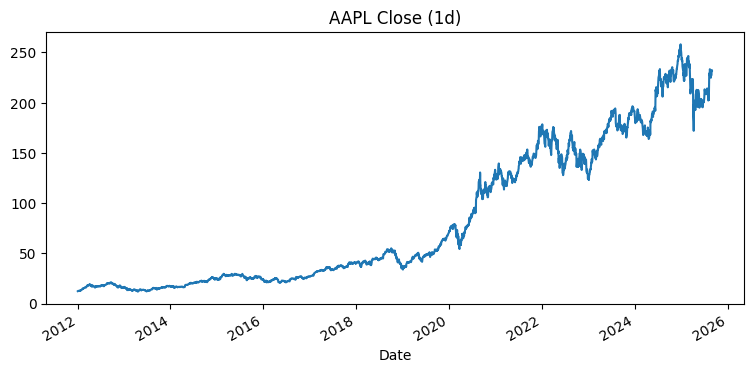

In [5]:
# --- Plot (safe) --------------------------------------------------------
df["close"].plot(title=f"{TICKER} Close ({INTERVAL})", figsize=(9,4))
plt.show()
# CHANGE: Plot-Safe — Figure schließen
plt.close()

In [6]:
# --- CSV einfrieren -----------------------------------------------------
csv_path = RAW_CSV
df.to_csv(csv_path, float_format="%.8f")
print("CSV gespeichert unter:", csv_path)

CSV gespeichert unter: ../data/AAPL_1d_2012-01-01_2025-09-01.csv


In [7]:
# --- Manifest & Profiling ----------------------------------------------
def _sha256_file(path, chunk=1<<20):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()

# CHANGE: tz + source in Manifest
tz_info = getattr(df.index, "tz", None)
tz_name = str(tz_info) if tz_info is not None else "naive"

manifest = {
    "ticker": TICKER, "interval": INTERVAL, "start": START, "end": END,
    "rows": int(len(df)),
    "first_ts": str(df.index.min()),
    "last_ts": str(df.index.max()),
    "sha256": _sha256_file(csv_path),
    "created_utc": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
    "tz": tz_name,                 # CHANGE
    "source": "yfinance"           # CHANGE
}
with open("../data/DATA_MANIFEST.json", "w") as f:
    json.dump(manifest, f, indent=2)

# CHANGE: Profiling erweitert um dup_timestamps & volume_zero_share
profiling = {
    "n": int(len(df)),
    "na_any": int(df.isna().any().any()),
    "close_min": float(df["close"].min()),
    "close_max": float(df["close"].max()),
    "logret_1d_mean": float(np.log(df["close"]).diff().dropna().mean()),
    "logret_1d_std": float(np.log(df["close"]).diff().dropna().std()),
    "dup_timestamps": dup_count,                                   # CHANGE
    "volume_zero_share": float((df["volume"]==0).mean())           # CHANGE
    # "n_after_dropna_features" wird in Block 2 ergänzt (nach Featurebau)  # CHANGE
}
with open("../data/profiling.json", "w") as f:
    json.dump(profiling, f, indent=2)

print("Manifest & Profiling geschrieben.")

Manifest & Profiling geschrieben.


In [8]:
import os, sys, json, yaml
from pathlib import Path
import numpy as np
import pandas as pd

ROOT = os.path.abspath("..")
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

# CHANGE: Config nur einmal laden (aus Block 1-Konvention)
with open(os.path.join(ROOT, "config.json"), "r") as f:
    C = json.load(f)

TICKER   = C["ticker"]
START    = C["start"]
END      = C["end"]
INTERVAL = C["interval"]
FEATURESET = C.get("featureset", "v2")

# Label/Train-Setup
HORIZON   = int(C.get("horizon", 5))
LOOKBACK  = int(C.get("lookback", 60))
EPS_MODE  = str(C.get("epsilon_mode", "abs"))
EPSILON   = float(C.get("epsilon", 0.0005))   # Baseline-epsilon

raw_csv_path = f"../data/{TICKER}_{INTERVAL}_{START}_{END}.csv"

In [9]:
# --- Preise lesen -------------------------------------------------------
from finance_lstm import read_prices
df_raw = read_prices(raw_csv_path)
assert (df_raw["close"] > 0).all()

In [10]:
# --- Featurebau ---------------------------------------------------------
def _rsi(close: pd.Series, n=14):
    r = close.diff().fillna(0.0)
    up  = r.clip(lower=0.0); dn = (-r).clip(lower=0.0)
    roll_up = up.rolling(n, min_periods=n).mean()
    roll_dn = dn.rolling(n, min_periods=n).mean()
    rs  = roll_up / (roll_dn + 1e-12)
    return 100.0 - (100.0 / (1.0 + rs))

def _macd(close: pd.Series, fast=12, slow=26, signal=9):
    ema_fast = close.ewm(span=fast, adjust=False, min_periods=fast).mean()
    ema_slow = close.ewm(span=slow, adjust=False, min_periods=slow).mean()
    macd = ema_fast - ema_slow
    macd_sig = macd.ewm(span=signal, adjust=False, min_periods=signal).mean()
    return macd, macd_sig, macd - macd_sig

def build_features_v2(frame: pd.DataFrame) -> pd.DataFrame:
    out = frame.copy()
    out["logret_1d"] = np.log(out["close"]).diff()
    out["logret_3d"] = out["logret_1d"].rolling(3,  min_periods=3).sum()
    out["logret_5d"] = out["logret_1d"].rolling(5,  min_periods=5).sum()
    out["realized_vol_10"] = out["logret_1d"].rolling(10, min_periods=10).std()
    sma20 = out["close"].rolling(20, min_periods=20).mean()
    std20 = out["close"].rolling(20, min_periods=20).std()
    out["bb_pos"] = (out["close"] - sma20) / (2.0*std20 + 1e-12)
    out["rsi_14"] = _rsi(out["close"], 14)
    macd, macd_sig, macd_diff = _macd(out["close"])
    out["macd"] = macd; out["macd_sig"] = macd_sig; out["macd_diff"] = macd_diff
    out["log_vol"] = np.log(out["volume"].replace(0, np.nan))
    roll_med = out["log_vol"].rolling(20, min_periods=20).median()
    roll_mad = out["log_vol"].rolling(20, min_periods=20).apply(
        lambda x: np.median(np.abs(x - np.median(x))), raw=True
    )
    # CHANGE: vorsichtig clippen, um Extremwerte zu entgrenzen
    out["vol_z_20"] = ((out["log_vol"] - roll_med) / (roll_mad + 1e-12)).clip(-10, 10)
    out["sma_diff"] = (out["close"].rolling(10, min_periods=10).mean() /
                       (out["close"].rolling(20, min_periods=20).mean() + 1e-12) - 1.0)
    return out

df_feat = build_features_v2(df_raw)

In [11]:
# --- Labeling (H=HORIZON) ----------------------------------------------
# Forward-Logreturn
fut = np.log(df_feat["close"]).shift(-HORIZON)
cur = np.log(df_feat["close"])
fwd_logret = fut - cur

# Chronologischer Split wie Training (70/15/15) — benötigt für Quantil ohne Leckage
n_total = len(df_feat)
n_train = int(n_total * 0.70)
n_val   = int(n_total * 0.15)
train_idx = slice(0, n_train)
val_idx   = slice(n_train, n_train + n_val)
test_idx  = slice(n_train + n_val, n_total)

# CHANGE: EPS-Logik — Quantil nur auf TRAIN bestimmen und einfrieren
if EPS_MODE == "quantile":
    # EPSILON wird als Quantil q ∈ (0,1) interpretiert; hier nur Train verwenden
    q = EPSILON if 0 < EPSILON < 1 else 0.6
    eps_val = float(fwd_logret.iloc[train_idx].quantile(q))
    eps_mode_used = f"q{q:.2f}"
else:
    eps_val = float(EPSILON)
    eps_mode_used = "abs"

# Hauptlabel (Kostenbasierte Schwelle)
df_feat["target"] = (fwd_logret > eps_val).astype("int8")

# CHANGE (Empfehlung): Volatilitäts-skaliertes Zusatzlabel (optional nutzbar)
z = fwd_logret / (df_feat["realized_vol_10"] + 1e-12)
df_feat["target_z"] = (z > 0.4).astype("int8")   # k≈0.3–0.5 testbar

# Aufräumen / initiales Dropna
df_clean = df_feat.dropna().sort_index()

In [12]:
# --- Profiling-Update: n_after_dropna_features -------------------------
# CHANGE: bestehende profiling.json erweitern
prof_path = Path("../data/profiling.json")
try:
    profiling = json.load(open(prof_path, "r")) if prof_path.exists() else {}
except Exception:
    profiling = {}
profiling["n_after_dropna_features"] = int(len(df_clean))
with open(prof_path, "w") as f:
    json.dump(profiling, f, indent=2)

In [13]:
# --- Featureliste + YAML mit Beschreibungen -----------------------------
features_list = [
    "logret_1d","logret_3d","logret_5d",
    "realized_vol_10","bb_pos","rsi_14",
    "macd","macd_sig","macd_diff",
    "vol_z_20","sma_diff",
]

# CHANGE: 1-Zeiler je Feature (Beschreibung + Fenster)
feature_docs = {
    "logret_1d": "Log-Return t→t+1 (1 Tag).",
    "logret_3d": "Summe Log-Returns über 3 Tage (rolling, mp=3).",
    "logret_5d": "Summe Log-Returns über 5 Tage (rolling, mp=5).",
    "realized_vol_10": "Realisiert. Std der 1d-Logreturns über 10 Tage.",
    "bb_pos": "Position relativ zu Bollinger-Bändern (SMA20±2*Std).",
    "rsi_14": "Relative Strength Index (14).",
    "macd": "EMA12-EMA26.",
    "macd_sig": "MACD Signal (EMA9 von MACD).",
    "macd_diff": "MACD minus Signal.",
    "vol_z_20": "Z-Score der Log-Volumen (Median/MAD über 20, clipped ±10).",
    "sma_diff": "SMA10/SMA20 - 1 (Trendverhältnis)."
}

feature_meta = {
    "name": f"features_{FEATURESET}",
    "features": features_list,
    "feature_docs": feature_docs,                 # CHANGE
    "label": {"horizon": HORIZON, "epsilon": eps_val, "mode": eps_mode_used},
    "note": "Nur rückwärtsgerichtete Rolling/EMA; keine Future-Leaks."
}
with open(f"../data/features_{FEATURESET}.yml", "w") as f:
    yaml.safe_dump(feature_meta, f, sort_keys=False)

In [14]:
# --- Export(e): ε-Sweep vorbereiten ------------------------------------
# CHANGE: Wir exportieren mehrere Trainings-CSV mit ε∈{EPSILON, 0.001, 0.002} (nur für abs-Mode sinnvoll)
eps_sweep = [eps_val] if EPS_MODE == "quantile" else sorted(set([eps_val, 0.001, 0.002]))

out_paths = []
for eps_out in eps_sweep:
    if EPS_MODE == "quantile":
        # Bei Quantil-Mode behalten wir eps_val (aus Train-Quantil) und kennzeichnen via mode-Tag
        eps_tag = f"{eps_mode_used}{str(eps_val).replace('.','p')}"
        target_series = (fwd_logret > eps_val).astype("int8")
    else:
        eps_tag = f"abs{str(eps_out).replace('.','p')}"
        target_series = (fwd_logret > eps_out).astype("int8")

    # neue DataFrame-Variante mit gewähltem Label
    df_out = df_feat.copy()
    df_out["target"] = target_series
    df_out = df_out.dropna().sort_index()

    train_csv_out = f"../data/{TICKER}_{INTERVAL}_{START}_{END}_cls_h{HORIZON}_{eps_tag}.csv"
    df_out.to_csv(train_csv_out, float_format="%.8f")
    out_paths.append(train_csv_out)
    print("Train-CSV:", train_csv_out, "| pos_rate:", round(df_out["target"].mean(),3), "| n:", len(df_out))

Train-CSV: ../data/AAPL_1d_2012-01-01_2025-09-01_cls_h1_abs0p0005.csv | pos_rate: 0.509 | n: 3402
Train-CSV: ../data/AAPL_1d_2012-01-01_2025-09-01_cls_h1_abs0p001.csv | pos_rate: 0.496 | n: 3402
Train-CSV: ../data/AAPL_1d_2012-01-01_2025-09-01_cls_h1_abs0p002.csv | pos_rate: 0.462 | n: 3402


In [15]:
# --- Targets-Summary (für Baseline-eps_val) -----------------------------
vc = df_clean["target"].value_counts().sort_index()
targets_summary = {
    "horizon": HORIZON, "epsilon": float(eps_val), "mode": eps_mode_used,
    "n": int(len(df_clean)),
    "class_counts": {int(k): int(v) for k, v in vc.items()},
    "pos_rate": float(vc.get(1,0)/vc.sum()) if vc.sum() else None,
    "exports": out_paths                                 # CHANGE: verlinke alle erzeugten CSVs
}
with open("../data/targets_summary.json", "w") as f:
    json.dump(targets_summary, f, indent=2)

print("targets_summary:", targets_summary)
print(df_clean[["close","logret_1d","target","target_z"]].head())

targets_summary: {'horizon': 1, 'epsilon': 0.0005, 'mode': 'abs', 'n': 3402, 'class_counts': {0: 1669, 1: 1733}, 'pos_rate': 0.5094062316284539, 'exports': ['../data/AAPL_1d_2012-01-01_2025-09-01_cls_h1_abs0p0005.csv', '../data/AAPL_1d_2012-01-01_2025-09-01_cls_h1_abs0p001.csv', '../data/AAPL_1d_2012-01-01_2025-09-01_cls_h1_abs0p002.csv']}
                close  logret_1d  target  target_z
Date                                              
2012-02-21  15.455862   0.025036       0         0
2012-02-22  15.401522  -0.003522       1         0
2012-02-23  15.502089   0.006508       1         1
2012-02-24  15.682808   0.011590       1         1
2012-02-27  15.783381   0.006392       1         1


In [16]:
# --- Sentinel für Block 3 -----------------------------------------------
label_run = {
    "train_csv": out_paths[0],  # Baseline-Datei zuerst in der Liste
    "features_yaml": f"../data/features_{FEATURESET}.yml",
    "label": {"horizon": HORIZON, "epsilon": float(eps_val), "mode": eps_mode_used},
}
with open("../data/LABEL_RUN.json", "w") as f:
    json.dump(label_run, f, indent=2)